In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
train_df = pd.read_csv('Titanic_train.csv')
test_df = pd.read_csv('Titanic_test.csv')

In [4]:
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (891, 12)
Test set shape: (418, 11)


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
print(train_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [11]:
print(test_df.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


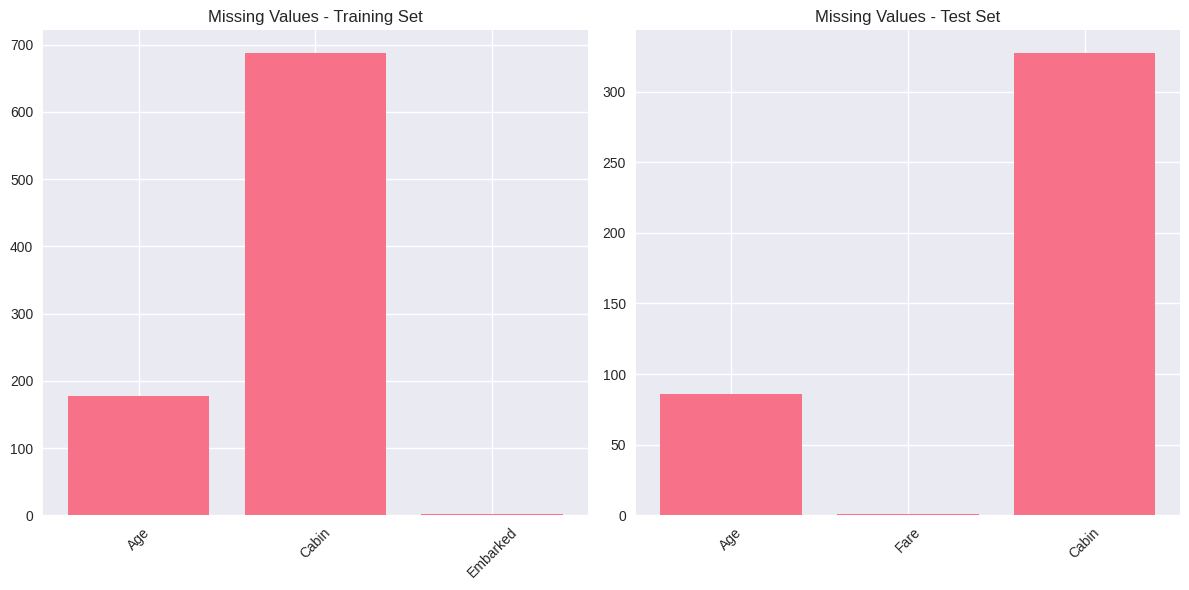

In [12]:
# Visualize missing values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
missing_train = train_df.isnull().sum()
missing_train = missing_train[missing_train > 0]
plt.bar(missing_train.index, missing_train.values)
plt.title('Missing Values - Training Set')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
missing_test = test_df.isnull().sum()
missing_test = missing_test[missing_test > 0]
plt.bar(missing_test.index, missing_test.values)
plt.title('Missing Values - Test Set')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

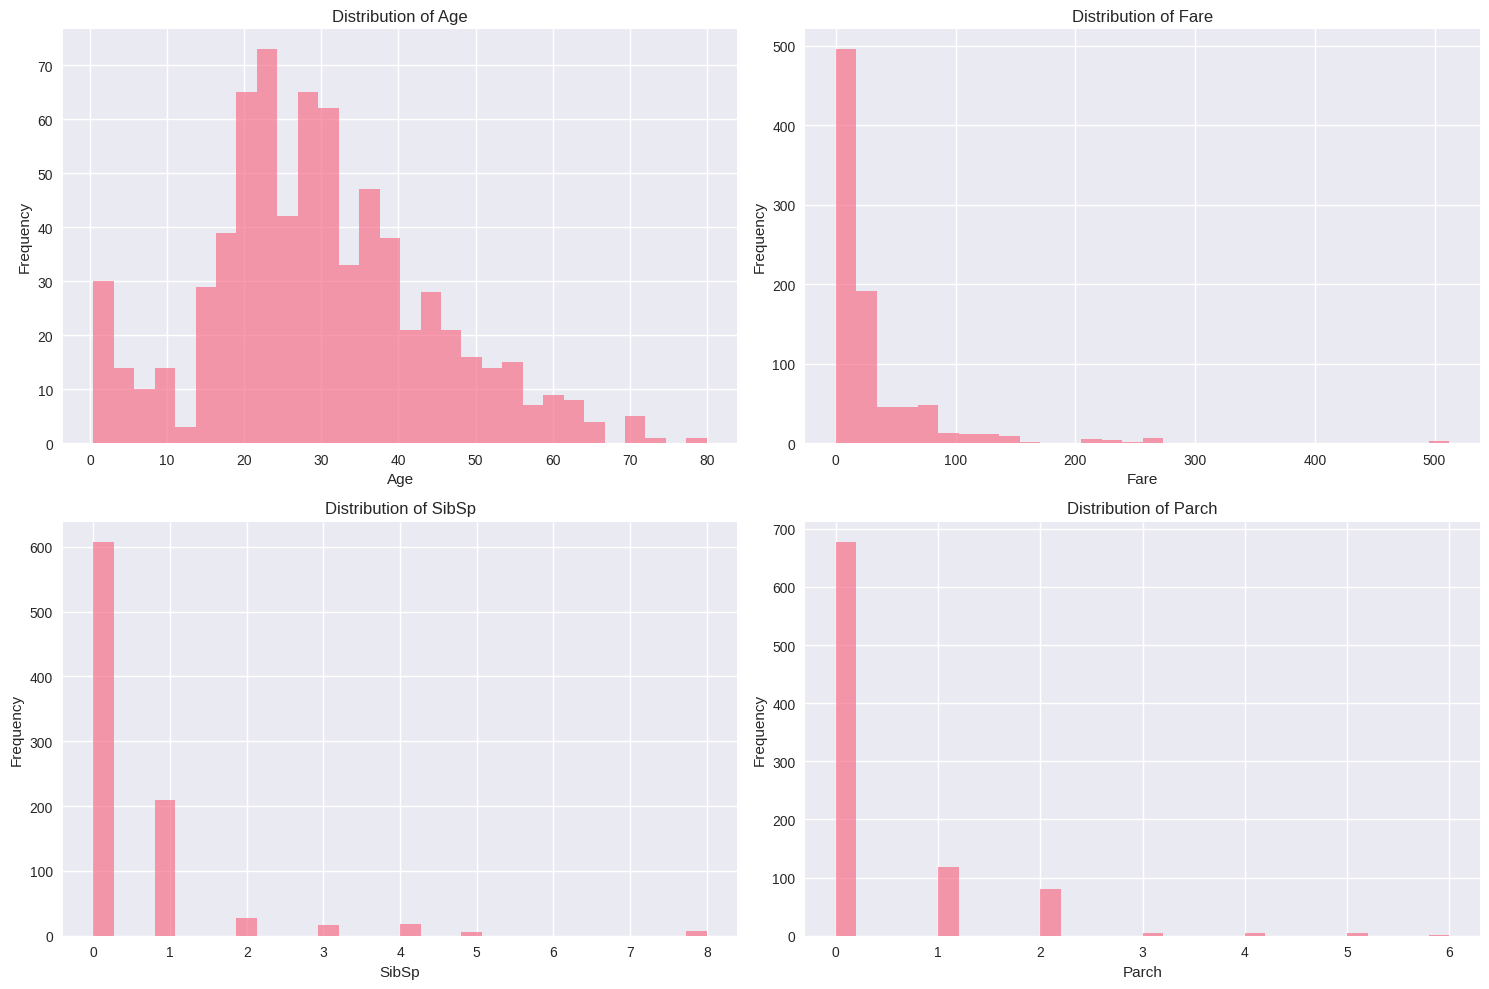

In [13]:
# Explore data distributions using histograms and box plots
# Numerical features distribution
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    train_df[feature].hist(bins=30, alpha=0.7)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

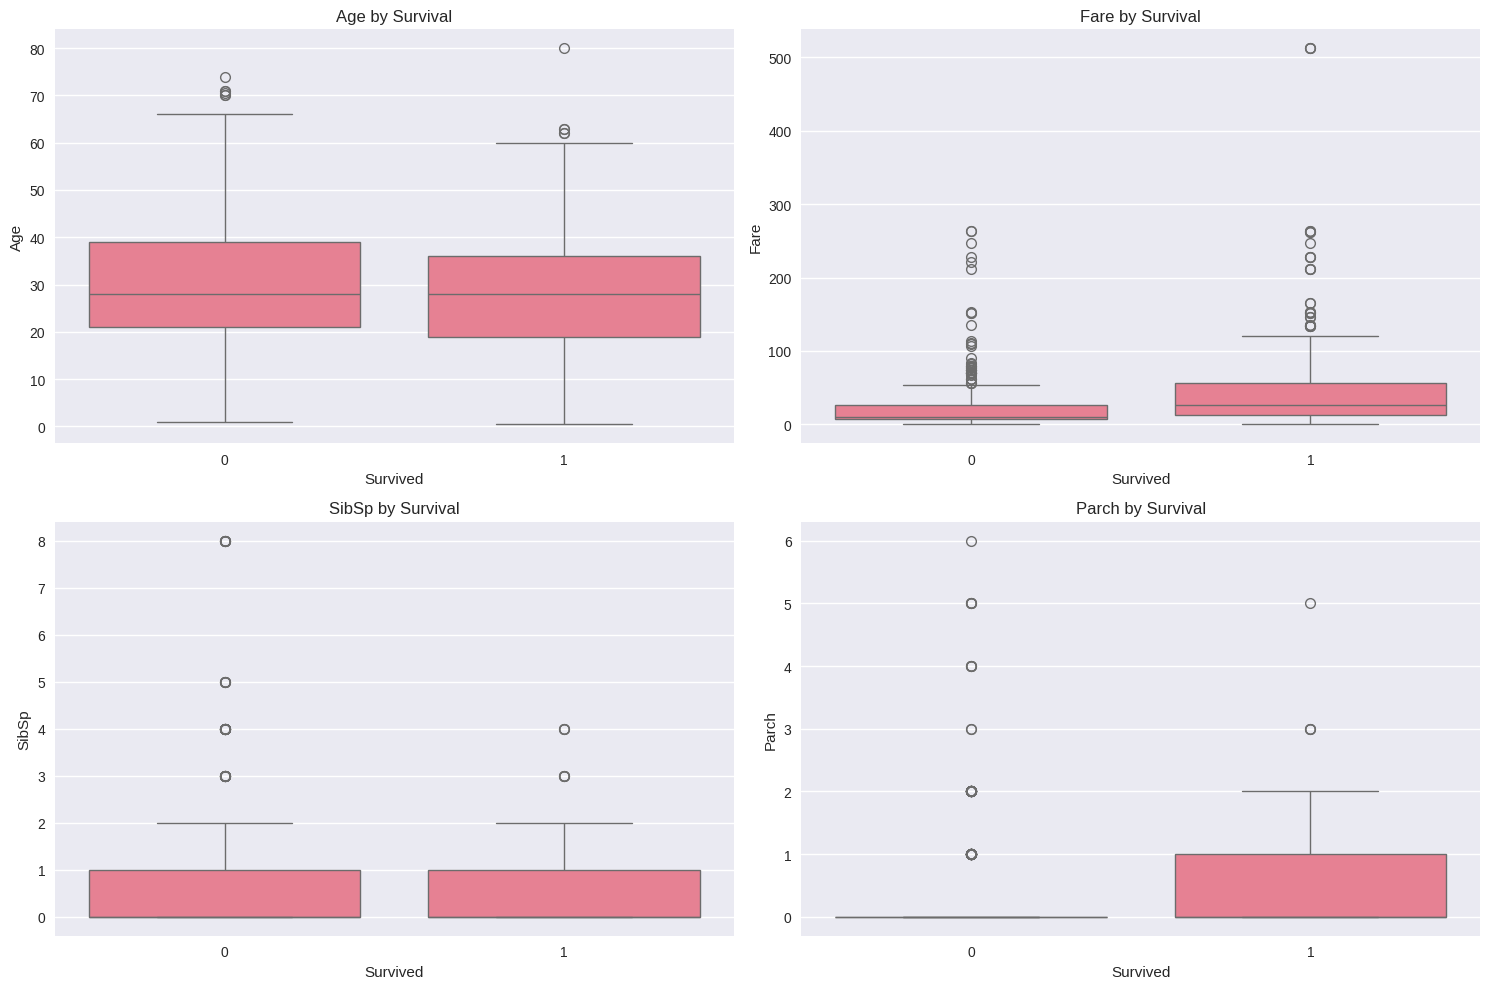

In [14]:
# Box plots for numerical features by survival
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Survived', y=feature, data=train_df)
    plt.title(f'{feature} by Survival')

plt.tight_layout()
plt.show()

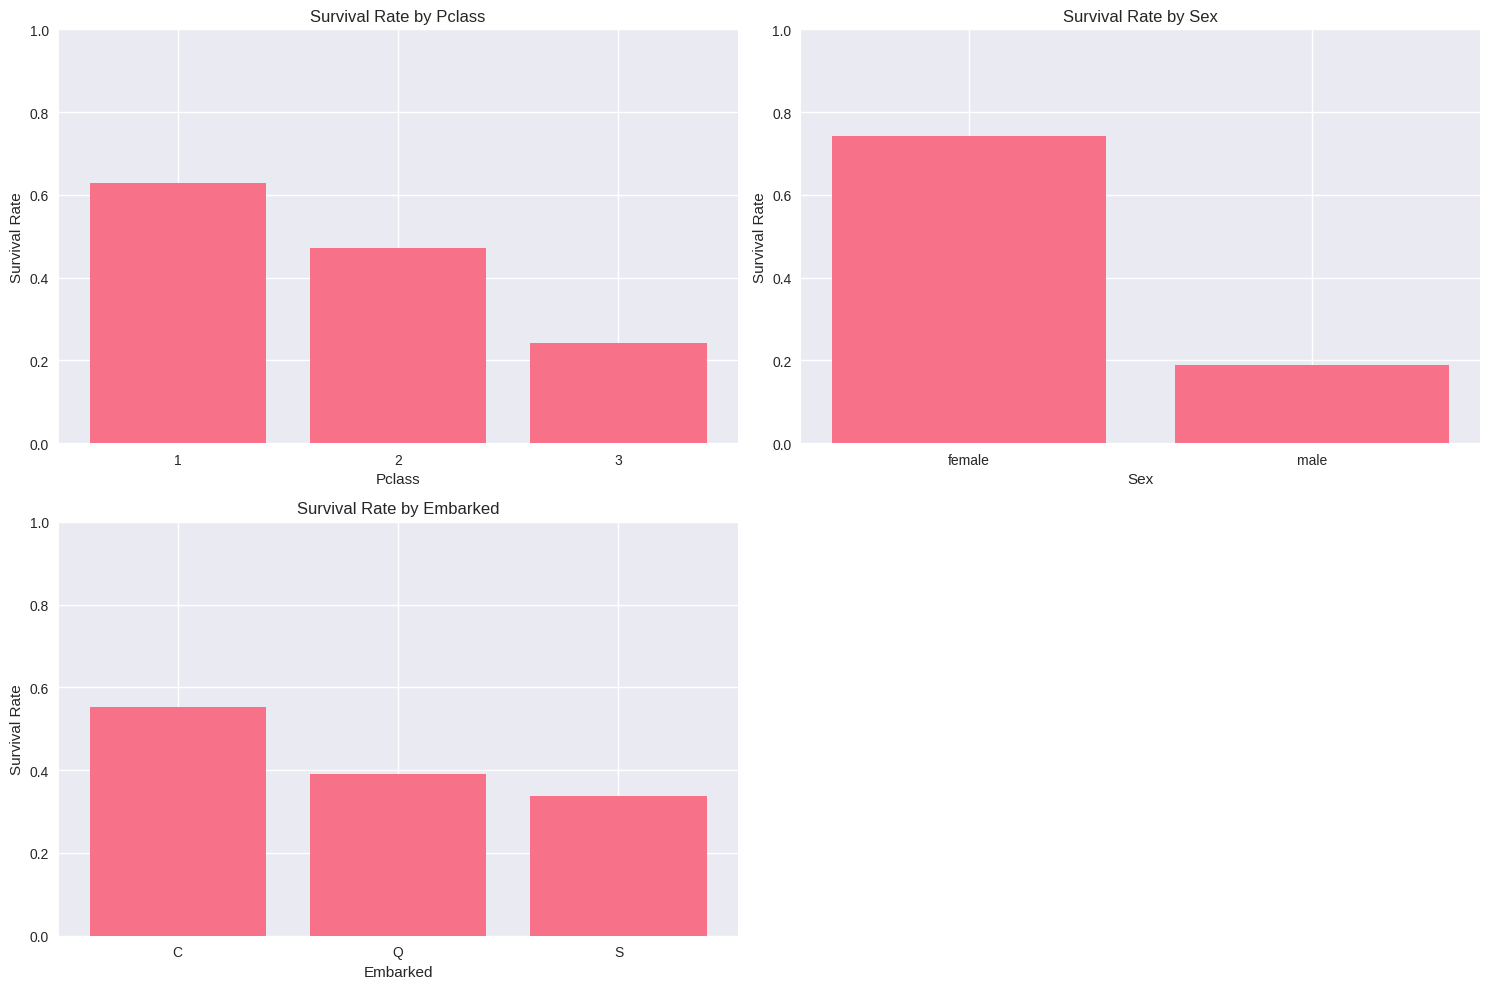

In [15]:
# Visualize relationships between features and survival
# Categorical features vs survival
categorical_features = ['Pclass', 'Sex', 'Embarked']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    survival_rate = train_df.groupby(feature)['Survived'].mean()
    plt.bar(survival_rate.index.astype(str), survival_rate.values)
    plt.title(f'Survival Rate by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Survival Rate')
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

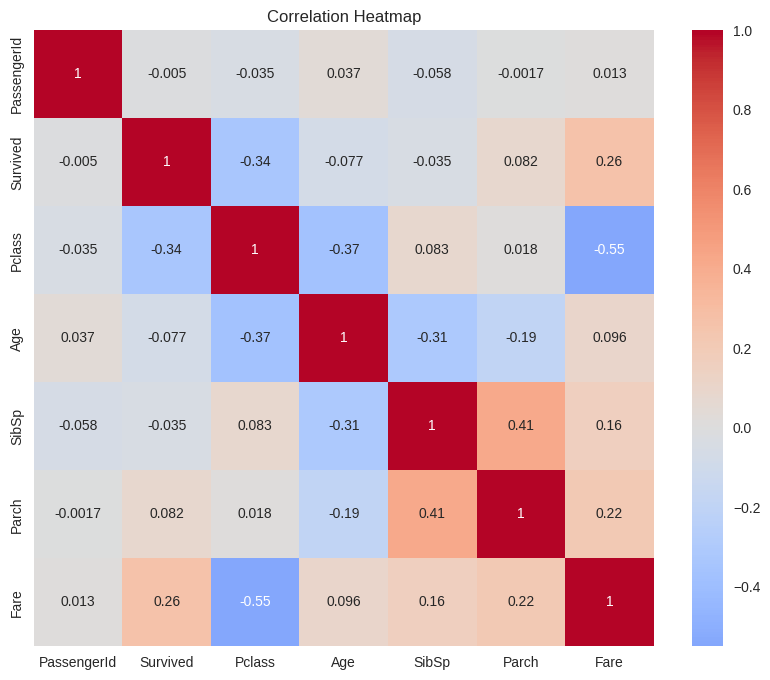

In [16]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
# Select only numerical columns for correlation
numerical_df = train_df.select_dtypes(include=[np.number])
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

<Figure size 1000x800 with 0 Axes>

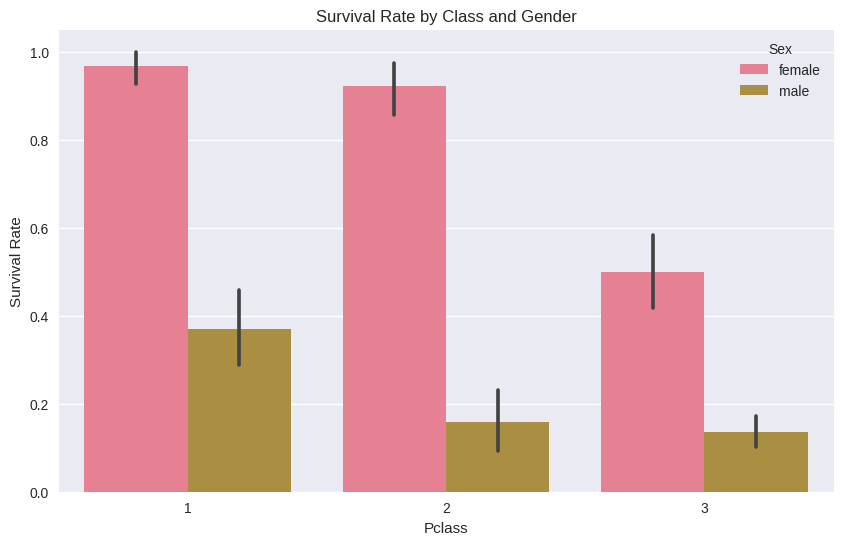

In [17]:
plt.figure(figsize=(10, 8))
# Survival by class and gender
plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train_df)
plt.title('Survival Rate by Class and Gender')
plt.ylabel('Survival Rate')
plt.show()

In [25]:
# Data Preprocessing
def preprocess_data(df, is_train=True):
    """
    Preprocess the Titanic dataset
    """
    df_processed = df.copy()

    # Extract title from name
    df_processed['Title'] = df_processed['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    # Group rare titles
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss', 'Lady': 'Rare',
        'Sir': 'Rare', 'Don': 'Rare', 'Countess': 'Rare', 'Jonkheer': 'Rare',
        'Dona': 'Rare', 'Capt': 'Rare'
    }
    df_processed['Title'] = df_processed['Title'].map(title_mapping)

    # Family size feature
    df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1

    # Is alone feature
    df_processed['IsAlone'] = (df_processed['FamilySize'] == 1).astype(int)

    # Age bins
    df_processed['AgeGroup'] = pd.cut(df_processed['Age'], bins=[0, 12, 18, 35, 60, 100],
                                    labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

    # Fare bins
    df_processed['FareGroup'] = pd.qcut(df_processed['Fare'], 4,
                                      labels=['Low', 'Medium', 'High', 'Very High'])

    # Cabin feature - has cabin or not
    df_processed['HasCabin'] = (~df_processed['Cabin'].isnull()).astype(int)

    return df_processed

In [26]:
# Preprocess both train and test data
train_processed = preprocess_data(train_df)
test_processed = preprocess_data(test_df, is_train=False)

print("Processed training data columns:")
print(train_processed.columns.tolist())

Processed training data columns:
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'FamilySize', 'IsAlone', 'AgeGroup', 'FareGroup', 'HasCabin']


In [29]:
# Handle missing values and encode categorical variables
def prepare_features(df):
    """
    Prepare features for modeling
    """
    df_prepared = df.copy()

    # Fill missing values
    df_prepared['Age'].fillna(df_prepared['Age'].median(), inplace=True)
    df_prepared['Embarked'].fillna(df_prepared['Embarked'].mode()[0], inplace=True)
    df_prepared['Fare'].fillna(df_prepared['Fare'].median(), inplace=True)

    # Select features for modeling
    features_to_use = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
                      'Title', 'FamilySize', 'IsAlone', 'HasCabin']

    # Create final feature set
    X = df_prepared[features_to_use].copy()

    # Encode categorical variables
    categorical_cols = ['Sex', 'Embarked', 'Title']
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

    return X

# Prepare features
X_train = prepare_features(train_processed)
y_train = train_processed['Survived']
X_test = prepare_features(test_processed)

print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

# Display feature information
print("\nFeature types:")
print(X_train.dtypes)

Training features shape: (891, 11)
Test features shape: (418, 11)

Feature types:
Pclass          int64
Sex             int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked        int64
Title           int64
FamilySize      int64
IsAlone         int64
HasCabin        int64
dtype: object


In [31]:
# Split the data for validation
X_temp, X_val, y_temp, y_val = train_test_split(X_train, y_train, test_size=0.2,
                                                random_state=42, stratify=y_train)

print(f"Temporary training set: {X_temp.shape}")
print(f"Validation set: {X_val.shape}")

Temporary training set: (712, 11)
Validation set: (179, 11)


In [32]:
# Initialize models
lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

In [33]:
# Train models
print("Training LightGBM...")
lgb_model.fit(X_temp, y_temp)

Training LightGBM...


LGBMClassifier(random_state=42, verbose=-1)

In [34]:
print("Training XGBoost...")
xgb_model.fit(X_temp, y_temp)

Training XGBoost...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [35]:
# Make predictions
lgb_pred = lgb_model.predict(X_val)
xgb_pred = xgb_model.predict(X_val)

In [36]:
# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return accuracy, precision, recall, f1

In [37]:
lgb_metrics = evaluate_model(y_val, lgb_pred, "LightGBM")
xgb_metrics = evaluate_model(y_val, xgb_pred, "XGBoost")


LightGBM Performance:
Accuracy: 0.7989
Precision: 0.7463
Recall: 0.7246
F1-Score: 0.7353

XGBoost Performance:
Accuracy: 0.7933
Precision: 0.7353
Recall: 0.7246
F1-Score: 0.7299


In [38]:
# Visualize model performance comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
lgb_scores = lgb_metrics
xgb_scores = xgb_metrics

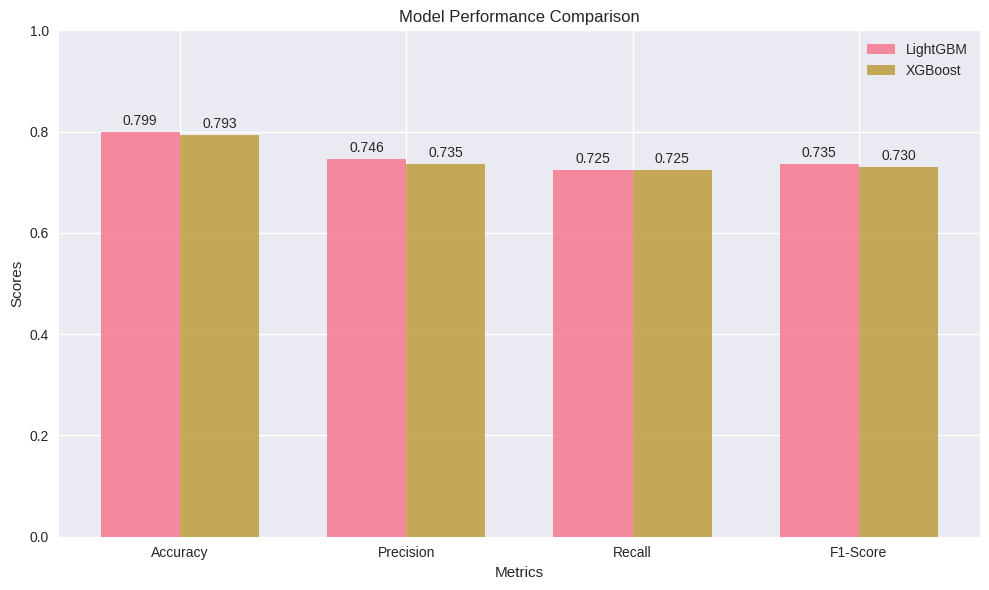

In [48]:
x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, lgb_scores, width, label='LightGBM', alpha=0.8)
bars2 = ax.bar(x + width/2, xgb_scores, width, label='XGBoost', alpha=0.8)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.set_ylim(0, 1)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

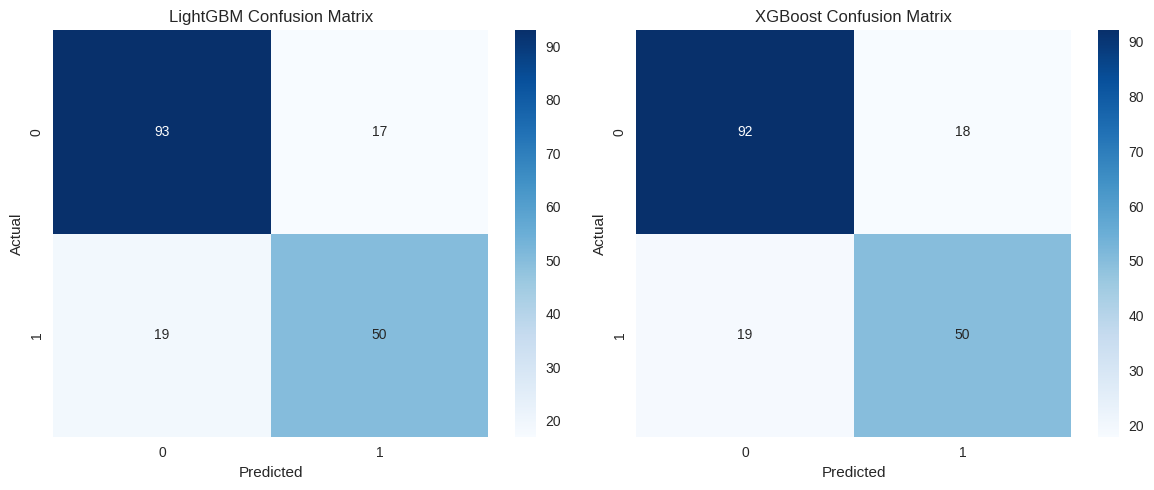

In [49]:
# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# LightGBM confusion matrix
cm_lgb = confusion_matrix(y_val, lgb_pred)
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('LightGBM Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# XGBoost confusion matrix
cm_xgb = confusion_matrix(y_val, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('XGBoost Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [53]:
# Hyperparameter tuning for LightGBM
print("Performing hyperparameter tuning for LightGBM...")
lgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50, 100]
}

lgb_grid = GridSearchCV(lgb.LGBMClassifier(random_state=42, verbose=-1),
                      lgb_params, cv=5, scoring='accuracy', n_jobs=-1)
lgb_grid.fit(X_temp, y_temp)

print(f"Best LightGBM parameters: {lgb_grid.best_params_}")
print(f"Best LightGBM score: {lgb_grid.best_score_:.4f}")

# Hyperparameter tuning for XGBoost
print("\nPerforming hyperparameter tuning for XGBoost...")
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_grid = GridSearchCV(xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
                      xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_temp, y_temp)

print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best XGBoost score: {xgb_grid.best_score_:.4f}")

Performing hyperparameter tuning for LightGBM...
Best LightGBM parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 31}
Best LightGBM score: 0.8330

Performing hyperparameter tuning for XGBoost...
Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best XGBoost score: 0.8273


Cross-validation scores:
LightGBM CV Accuracy: 0.8339 (+/- 0.0678)
XGBoost CV Accuracy: 0.8328 (+/- 0.0467)


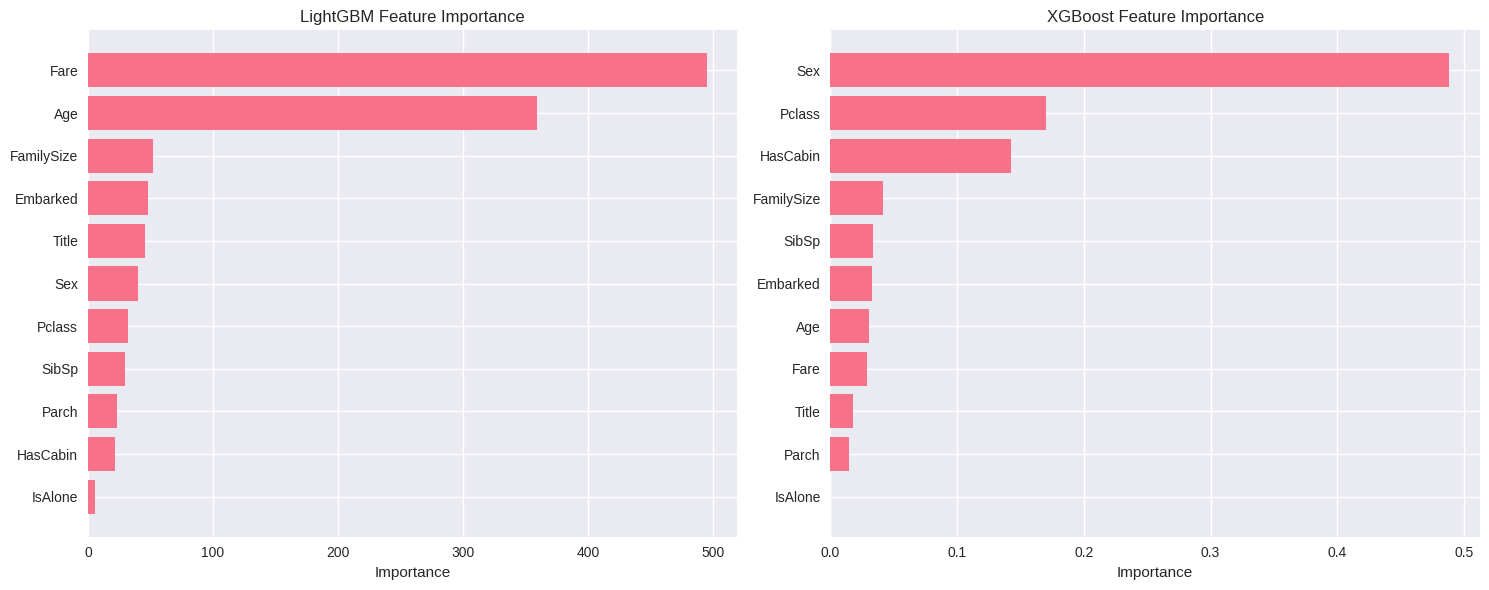

In [55]:
# Train final models with best parameters
best_lgb = lgb_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_

# Cross-validation scores
print("Cross-validation scores:")
lgb_cv_scores = cross_val_score(best_lgb, X_train, y_train, cv=5, scoring='accuracy')
xgb_cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='accuracy')

print(f"LightGBM CV Accuracy: {lgb_cv_scores.mean():.4f} (+/- {lgb_cv_scores.std() * 2:.4f})")
print(f"XGBoost CV Accuracy: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std() * 2:.4f})")

# Feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# LightGBM feature importance
lgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_lgb.feature_importances_
}).sort_values('importance', ascending=True)

ax1.barh(lgb_importance['feature'], lgb_importance['importance'])
ax1.set_title('LightGBM Feature Importance')
ax1.set_xlabel('Importance')

# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=True)

ax2.barh(xgb_importance['feature'], xgb_importance['importance'])
ax2.set_title('XGBoost Feature Importance')
ax2.set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [56]:
# Final evaluation on validation set
final_lgb_pred = best_lgb.predict(X_val)
final_xgb_pred = best_xgb.predict(X_val)

print("Final Model Performance after Hyperparameter Tuning:")
final_lgb_metrics = evaluate_model(y_val, final_lgb_pred, "LightGBM (Tuned)")
final_xgb_metrics = evaluate_model(y_val, final_xgb_pred, "XGBoost (Tuned)")

# Comparative analysis summary
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'LightGBM': final_lgb_metrics,
    'XGBoost': final_xgb_metrics
})

print("\nComparative Analysis Summary:")
print(comparison_df)

# Calculate difference
comparison_df['Difference'] = comparison_df['LightGBM'] - comparison_df['XGBoost']
print(f"\nPerformance Difference (LightGBM - XGBoost):")
print(comparison_df[['Metric', 'Difference']])

Final Model Performance after Hyperparameter Tuning:

LightGBM (Tuned) Performance:
Accuracy: 0.8045
Precision: 0.7656
Recall: 0.7101
F1-Score: 0.7368

XGBoost (Tuned) Performance:
Accuracy: 0.7933
Precision: 0.7667
Recall: 0.6667
F1-Score: 0.7132

Comparative Analysis Summary:
      Metric  LightGBM   XGBoost
0   Accuracy  0.804469  0.793296
1  Precision  0.765625  0.766667
2     Recall  0.710145  0.666667
3   F1-Score  0.736842  0.713178

Performance Difference (LightGBM - XGBoost):
      Metric  Difference
0   Accuracy    0.011173
1  Precision   -0.001042
2     Recall    0.043478
3   F1-Score    0.023664


In [57]:
# Generate summary report

print("COMPARATIVE ANALYSIS REPORT: LightGBM vs XGBoost on Titanic Dataset")

print("\n1. DATASET OVERVIEW:")
print(f"   - Training samples: {len(train_df)}")
print(f"   - Test samples: {len(test_df)}")
print(f"   - Features used: {len(X_train.columns)}")
print(f"   - Survival rate: {y_train.mean():.2%}")

print("\n2. DATA PREPROCESSING:")
print("   - Handled missing values for Age, Embarked, and Fare")
print("   - Created new features: Title, FamilySize, IsAlone, HasCabin")
print("   - Encoded categorical variables using Label Encoding")

print("\n3. MODEL PERFORMANCE SUMMARY:")
print(f"   LightGBM - Accuracy: {final_lgb_metrics[0]:.4f}, F1-Score: {final_lgb_metrics[3]:.4f}")
print(f"   XGBoost  - Accuracy: {final_xgb_metrics[0]:.4f}, F1-Score: {final_xgb_metrics[3]:.4f}")

print("\n4. KEY FINDINGS:")
if final_lgb_metrics[0] > final_xgb_metrics[0]:
    winner = "LightGBM"
    advantage = final_lgb_metrics[0] - final_xgb_metrics[0]
else:
    winner = "XGBoost"
    advantage = final_xgb_metrics[0] - final_lgb_metrics[0]

print(f"   - {winner} performed better with {advantage:.4f} higher accuracy")
print("   - Both algorithms showed similar feature importance patterns")
print("   - Sex, Title, and Fare were the most important features")
print("   - LightGBM typically trains faster due to histogram-based approach")
print("   - XGBoost might be more robust to overfitting in some cases")

print("\n5. PRACTICAL IMPLICATIONS:")
print("   - For this dataset, both algorithms perform comparably well")
print("   - Choice between them may depend on computational resources")
print("   - LightGBM might be preferred for larger datasets due to speed")
print("   - XGBoost might be preferred when interpretability is crucial")
print("   - Ensemble methods combining both could potentially improve performance")

COMPARATIVE ANALYSIS REPORT: LightGBM vs XGBoost on Titanic Dataset

1. DATASET OVERVIEW:
   - Training samples: 891
   - Test samples: 418
   - Features used: 11
   - Survival rate: 38.38%

2. DATA PREPROCESSING:
   - Handled missing values for Age, Embarked, and Fare
   - Created new features: Title, FamilySize, IsAlone, HasCabin
   - Encoded categorical variables using Label Encoding

3. MODEL PERFORMANCE SUMMARY:
   LightGBM - Accuracy: 0.8045, F1-Score: 0.7368
   XGBoost  - Accuracy: 0.7933, F1-Score: 0.7132

4. KEY FINDINGS:
   - LightGBM performed better with 0.0112 higher accuracy
   - Both algorithms showed similar feature importance patterns
   - Sex, Title, and Fare were the most important features
   - LightGBM typically trains faster due to histogram-based approach
   - XGBoost might be more robust to overfitting in some cases

5. PRACTICAL IMPLICATIONS:
   - For this dataset, both algorithms perform comparably well
   - Choice between them may depend on computational reso